<a href="https://colab.research.google.com/github/jaehyun0220/Colab/blob/master/SDS_PublicData_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3조. 건강검진 데이터를 활용한 치아우식증 발생 예측
#### # Ver 8. ML 모델 선택

In [1]:
# Auth 인증 및 Google Drive 활용 Data load
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


#### #2. 작업환경 세팅

In [2]:
# woe package install
! pip install woe

In [3]:
# 기본 라이브러리 로드
import pandas as pd
import numpy as np
import os, sys

from tqdm import tqdm_notebook

import re
import tensorflow as tf

#데이터 전처리 관련 라이브러리 로드
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit

#모델 알고리즘 로드
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

#차원축소 알고리즘 로드
from sklearn.decomposition import PCA

# Calculate IV Setting
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import string
import woe
from woe.eval import plot_ks

# Deep Learning Model 로드
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation 
from keras.wrappers.scikit_learn import KerasClassifier

#HyperParameter Tuning을 위한 라이브러리 로드
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#모델 평가를 위한 라이브러리 로드
from sklearn import metrics, model_selection
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

#수학 & 통계 관련 라이브러리 로드
import scipy.stats as st
from collections import Counter
import math

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Visualization
import seaborn as sns
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도


#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

Using TensorFlow backend.


#### #3.사용할 사용자 함수 정의

In [0]:
def auc_graph(roc_auc, fpr, tpr):
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

# Define a binning function for continous independent variables
max_bin = 20
force_bin = 3

def mono_bin(Y, X, n = max_bin):
  df1 = pd.DataFrame({"X": X, "Y": Y})
  justmiss = df1[['X','Y']][df1.X.isnull()]
  notmiss = df1[['X','Y']][df1.X.notnull()]
  r = 0
  while np.abs(r) < 1:
    try:
      global d1
      global d2
      d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
      d2 = d1.groupby('Bucket', as_index=True)
      r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
      n = n - 1 
    except Exception as e:
      n = n - 1
      break
      
  if len(d2) == 1:
    n = force_bin         
    bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
    if len(np.unique(bins)) == 2:
        bins = np.insert(bins, 0, 1)
        bins[1] = bins[1]-(bins[1]/2)
    d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
    d2 = d1.groupby('Bucket', as_index=True)

  d3 = pd.DataFrame({},index=[])
  d3["MIN_VALUE"] = d2.min().X
  d3["MAX_VALUE"] = d2.max().X
  d3["COUNT"] = d2.count().Y
  d3["EVENT"] = d2.sum().Y
  d3["NONEVENT"] = d2.count().Y - d2.sum().Y
  d3=d3.reset_index(drop=True)

  if len(justmiss.index) > 0:
      d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
      d4["MAX_VALUE"] = np.nan
      d4["COUNT"] = justmiss.count().Y
      d4["EVENT"] = justmiss.sum().Y
      d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
      d3 = d3.append(d4,ignore_index=True)

  d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
  d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
  d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
  d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
  d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["VAR_NAME"] = "VAR"
  d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
  d3 = d3.replace([np.inf, -np.inf], 0)
  d3.IV = d3.IV.sum()

  return(d3)
  
# Define a binning function for categorical independent variables
def char_bin(Y, X):
  df1 = pd.DataFrame({"X": X, "Y": Y})
  justmiss = df1[['X','Y']][df1.X.isnull()]
  notmiss = df1[['X','Y']][df1.X.notnull()]    
  df2 = notmiss.groupby('X',as_index=True)

  d3 = pd.DataFrame({},index=[])
  d3["COUNT"] = df2.count().Y
  d3["MIN_VALUE"] = df2.sum().Y.index
  d3["MAX_VALUE"] = d3["MIN_VALUE"]
  d3["EVENT"] = df2.sum().Y
  d3["NONEVENT"] = df2.count().Y - df2.sum().Y

  if len(justmiss.index) > 0:
    d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
    d4["MAX_VALUE"] = np.nan
    d4["COUNT"] = justmiss.count().Y
    d4["EVENT"] = justmiss.sum().Y
    d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
    d3 = d3.append(d4,ignore_index=True)

  d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
  d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
  d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
  d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
  d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["VAR_NAME"] = "VAR"
  d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
  d3 = d3.replace([np.inf, -np.inf], 0)
  d3.IV = d3.IV.sum()
  d3 = d3.reset_index(drop=True)

  return(d3)

# Calculate Information Values
def calc_iv_all(df1, target):
    
  stack = traceback.extract_stack()
  filename, lineno, function_name, code = stack[-2]
  vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
  final = (re.findall(r"[\w']+", vars_name))[-1]

  x = df1.dtypes.index
  count = -1

  for i in tqdm_notebook(x):
    if i.upper() not in (final.upper()):
      if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
        conv = mono_bin(target, df1[i])
        conv["VAR_NAME"] = i
        count = count + 1
      else:
        conv = char_bin(target, df1[i])
        conv["VAR_NAME"] = i            
        count = count + 1

      if count == 0:
        iv_df = conv
      else:
        iv_df = iv_df.append(conv,ignore_index=True)

  iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
  iv = iv.reset_index()
  return(iv_df,iv)

#### #4.원천 데이터 load 및 seed 설정

In [5]:
set_random_seed = 2580 # seed 지정
target_nm = 'dental_carries' # 타겟 변수 지정

#### 2013년 기준 #########################################################################################################################################
df_raw_2013 = pd.read_csv('../gdrive/My Drive/sds/data/NHIS_OPEN_GJ_2013_eng.csv', encoding = 'euc-kr')

# 컬럼명 내 불필요한 공백 및 특수문자 제거
df_raw_2013.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)

# 구강검진 결과가 있는 데이터셋만 load
df_data = df_raw_2013[df_raw_2013['examine_mouth']==1]

# 분석과 관련 없는 변수 및 기타 점검이 어려운 치아 관련 변수 삭제 
del_cols = ['baseyear', 'id', 'data_open_date','examine_mouth']
df_data.drop(columns=del_cols, axis=1, inplace=True)

# 치아우식증 결과가 있는 데이터만 끌고 옴
df_data = df_data[~(df_data['dental_carries'].isnull()) & (df_data['dental_carries'] != 2)]

# null 포함 데이터 모두 삭제 
df_data.dropna(how='any', inplace=True)
display(df_data.info())
print(len(df_data))

print(df_data[target_nm].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380657 entries, 3 to 999998
Data columns (total 30 columns):
sex                      380657 non-null int64
ageband                  380657 non-null int64
province                 380657 non-null int64
height                   380657 non-null int64
weight                   380657 non-null int64
waist                    380657 non-null int64
sight_l                  380657 non-null float64
sight_r                  380657 non-null float64
hearing_l                380657 non-null float64
hearing_r                380657 non-null float64
bp_systolic              380657 non-null int64
bp_diastolic             380657 non-null int64
bs_before                380657 non-null int64
tot_cholesterol          380657 non-null int64
triglycerides            380657 non-null int64
HDL_cholesterol          380657 non-null int64
LDL_cholesterol          380657 non-null float64
hemoglobin               380657 non-null float64
piu                      380657

None

380657
0.0    288017
1.0     92640
Name: dental_carries, dtype: int64


#### #5. 데이터샘플링 및 Wrangling

In [6]:
df_sample = df_data.copy()
print(df_sample[target_nm].value_counts())

0.0    288017
1.0     92640
Name: dental_carries, dtype: int64


In [0]:
# 명목형 변수 변경
category_features = ['sex', 'ageband', 'height', 'weight','province', 'hearing_l', 'hearing_r', 'smoking','drinking', 'piu', 'missing_tooth', 'dental_abrasion', 'wisdom_teeth_abnormal', 'plaque']

for col in df_data.columns:
  if col in category_features:
    df_sample[col] = df_sample[col].astype(object)

##### #5-1.내부 명목형 변수 묶기

In [0]:
# 명목형 변수의 범주화
# 성별코드 변환
df_sample["C_sex"] = df_sample["sex"].apply(lambda x:  'Male' if x == 1 else 'Female')

# 연령대코드 5세 단위 변환
min_age_code = df_sample["ageband"].min()

df_sample["C_ageband"] = df_sample["ageband"].apply(lambda x:  (x-1)*5 + 20 if min_age_code == 1 else (x-1)*5).astype(object)

# 시도코드 변환
df_sample["C_province"] = np.where(df_sample['province'] == 11, 'Seoul', 
                            np.where(df_sample['province']== 26, 'Busan', 
                              np.where(df_sample['province'] == 27, 'Daegu', 
                                np.where(df_sample['province'] == 28, 'Incheon', 
                                  np.where(df_sample['province'] == 29, 'Kwangju', 
                                    np.where(df_sample['province'] == 30, 'Daejeon', 
                                      np.where(df_sample['province'] == 31, 'Ulsan', 
                                        np.where(df_sample['province'] == 36, 'Sejong', 
                                          np.where(df_sample['province'] == 41, 'Gyeonggi', 
                                            np.where(df_sample['province'] == 42, 'Gangwon', 
                                              np.where(df_sample['province'] == 43, 'Chungbuk', 
                                                np.where(df_sample['province'] == 44, 'Chungnam', 
                                                  np.where(df_sample['province'] == 45, 'Jeonbuk', 
                                                    np.where(df_sample['province'] == 46, 'Jeonnam', 
                                                      np.where(df_sample['province'] == 47, 'Gyungbuk', 
                                                        np.where(df_sample['province'] == 48, 'Gyungnam', 
                                                          np.where(df_sample['province'] == 49, 'Jeju', 'Err')
                                      ))))))))))))))))

# 청력좌  변환
df_sample["C_hearing_l"] = df_sample["hearing_l"].apply(lambda x:  'Normal' if x == 1 else 'Abnormal')

# 청력우  변환
df_sample["C_hearing_r"] = df_sample["hearing_r"].apply(lambda x:  'Normal' if x == 1 else 'Abnormal')

# 요단백  변환
df_sample["C_piu"] = df_sample["piu"].apply(lambda x:  'Negative' if x == 1 else 'Positive')

# 흡연상태  변환
df_sample["C_smoking"] = df_sample["smoking"].apply(lambda x:  'NonSmoking' if x == 1 else ('StopSmoking' if x==2 else 'Smoking'))

# 음주여부  변환
df_sample["C_drinking"] = df_sample["drinking"].apply(lambda x:  'NonDrinking' if x == 0 else 'Drinking')

# 결손치 여부  변환
df_sample["C_missing_tooth"] = df_sample["missing_tooth"].apply(lambda x:  'Normal' if x == 0 else 'Abnormal')

# 치석 여부  변환
df_sample["C_dental_abrasion"] = df_sample["dental_abrasion"].apply(lambda x:  'Normal' if x == 0 else 'Abnormal')

# 치석 여부  변환
df_sample["C_wisdom_teeth_abnormal"] = df_sample["wisdom_teeth_abnormal"].apply(lambda x:  'Normal' if x == 0 else 'Abnormal')

# 치석 여부  변환
df_sample["C_plaque"] = df_sample["plaque"].apply(lambda x:  'Normal' if x == 0 else 'Abnormal')

# 변환 명목형 원 컬럼 삭제
del_obj_trans_cols = ['sex', 'ageband', 'province', 'hearing_l', 'hearing_r', 'piu', 'smoking', 'drinking', 'missing_tooth', 'dental_abrasion', 'wisdom_teeth_abnormal', 'plaque']
df_sample.drop(columns=del_obj_trans_cols, axis=1, inplace=True)

##### #5-2. 내부 수치형 변수 구간화

##### #5-3. 내부 수치형 변수 정규화

In [0]:
# 수치형 변수들 중 분포 이슈로 log 값을 취할 필요 있는 변수들 추출
num_ln_target_features = ['sight_l', 'sight_r', 'AST','ALT', 'bs_before','serum_creatinine','GammaGTP','tot_cholesterol', 'triglycerides']

# Feature Engineering의 일환으로 Log 값 취한 뒤 Normalization을 하여 변수명 + LN (lognorm)으로 열 추가 후 그래프 다시 그림
num_ln_cols = list(map(lambda x: "LN_"+str(x), num_ln_target_features))

num_pipeline = Pipeline([
        ('log_scaler', FunctionTransformer(np.log1p, validate=True)), # pipeline 내 log transformation을 위해 Function Transfomer 사용
        ('normalizer', MinMaxScaler()),
    ])

piped_np = num_pipeline.fit_transform(df_sample[num_ln_target_features])
piped_df = pd.DataFrame(piped_np, columns=num_ln_cols)

piped_df.head()

df_sample.drop(columns=num_ln_target_features, axis=1, inplace=True)

In [10]:
print("Before Re-indexing: Data count is ", len(df_sample))
df_sample.drop_duplicates()
df_sample.reset_index(inplace=True, drop=True)
print("After Re-indexing: Data count is ", len(df_sample))

df_fe = pd.concat([df_sample, piped_df], axis=1)
df_fe.head()

Before Re-indexing: Data count is  380657
After Re-indexing: Data count is  380657


,height,weight,waist,bp_systolic,bp_diastolic,HDL_cholesterol,LDL_cholesterol,hemoglobin,dental_carries,C_sex,C_ageband,C_province,C_hearing_l,C_hearing_r,C_piu,C_smoking,C_drinking,C_missing_tooth,C_dental_abrasion,C_wisdom_teeth_abnormal,C_plaque,LN_sight_l,LN_sight_r,LN_AST,LN_ALT,LN_bs_before,LN_serum_creatinine,LN_GammaGTP,LN_tot_cholesterol,LN_triglycerides
0,145,40,62,110,70,87,110.0,12.4,1.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.260671,0.260671,0.324587,0.242257,0.273586,0.097408,0.393001,0.562271,0.524264
1,145,45,72,100,53,46,140.0,13.1,1.0,Female,20,Seoul,Normal,Normal,Negative,NonSmoking,Drinking,Normal,Normal,Normal,Abnormal,0.214731,0.037939,0.313473,0.301486,0.300466,0.110197,0.313119,0.560370,0.632675
2,145,60,81,119,79,55,1494.0,12.7,0.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.105152,0.214731,0.430787,0.469957,0.389152,0.083842,0.412729,0.578979,0.544586
3,150,40,61,132,88,83,33.0,13.7,0.0,Female,20,Gyungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Abnormal,0.214731,0.214731,0.353958,0.301486,0.328540,0.122296,0.258977,0.364558,0.511384
4,150,40,61,95,65,56,83.0,12.4,0.0,Female,20,Gyeonggi,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Abnormal,0.135235,0.135235,0.344750,0.362609,0.289235,0.083842,0.258977,0.438554,0.539037


#### #6. 외부변수 추가

In [11]:
df_add1 = pd.read_csv('../gdrive/My Drive/sds/data/DentalExamineResult_2014_PortionbyTotInspector.csv', encoding = 'euc-kr')
df_add2 = pd.read_csv('../gdrive/My Drive/sds/data/KOSIS_AgeSex_AverageDentalVisitCnt_2012.csv', encoding = 'euc-kr')
df_add3 = pd.read_csv('../gdrive/My Drive/sds/data/KOSIS_DentalPrevalenceTrend_2012.csv', encoding = 'euc-kr')
df_add4 = pd.read_csv('../gdrive/My Drive/sds/data/chs_12_final_from_python.csv', encoding = 'euc-kr')

# Multiple Key를 사용하여 Join
# left_on=['column_name1','column_name2'], right_on = ['column_name3','column_name4']
print(len(df_fe))

df_new = pd.merge(left=df_fe, right=df_add1, how='outer', left_on=['C_province','C_sex'], right_on = ['Province','Sex'], sort=False)
df_new.drop(columns=['Province','Sex'], axis=1, inplace=True)
display(df_new.head())
print(len(df_new))

df_new = pd.merge(left=df_new, right=df_add2, how='outer', left_on=['C_ageband','C_sex'], right_on = ['Ageband','Sex'], sort=False)
df_new.drop(columns=['Ageband','Sex'], axis=1, inplace=True)
display(df_new.head())
print(len(df_new))

df_new = pd.merge(left=df_new, right=df_add3, how='outer', left_on=['C_ageband','C_sex'], right_on = ['Ageband','Sex'], sort=False)
df_new.drop(columns=['Ageband','Sex'], axis=1, inplace=True)
display(df_new.head())
print(len(df_new))

df_new = pd.merge(left=df_new, right=df_add4, how='left', left_on=['C_ageband','C_sex','C_province', 'weight', 'height'], right_on = ['R_ageband','R_sex','R_province','R_weight','R_height'], sort=False)
df_new.drop(columns=['R_ageband','R_sex','R_province','R_weight','R_height'], axis=1, inplace=True)
display(df_new.head())
print(len(df_new))

display(df_new.info())

380657


,height,weight,waist,bp_systolic,bp_diastolic,HDL_cholesterol,LDL_cholesterol,hemoglobin,dental_carries,C_sex,C_ageband,C_province,C_hearing_l,C_hearing_r,C_piu,C_smoking,C_drinking,C_missing_tooth,C_dental_abrasion,C_wisdom_teeth_abnormal,C_plaque,LN_sight_l,LN_sight_r,LN_AST,LN_ALT,LN_bs_before,LN_serum_creatinine,LN_GammaGTP,LN_tot_cholesterol,LN_triglycerides,A_NormalA_Result,A_NormalB_Result,A_Caution_Result,A_NeedCare_Result,A_Nutrition_Edu,A_Hygine_Edu,A_Fluoride_Edu,A_Examine_Rec,A_Care_Rec,A_Carries_Rec,A_Cure_Rec
0,145,40,62,110,70,87,110.0,12.4,1.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.260671,0.260671,0.324587,0.242257,0.273586,0.097408,0.393001,0.562271,0.524264,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09
1,145,60,81,119,79,55,1494.0,12.7,0.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.105152,0.214731,0.430787,0.469957,0.389152,0.083842,0.412729,0.578979,0.544586,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09
2,150,40,74,100,60,62,75.0,13.3,0.0,Female,20,Chungbuk,Normal,Normal,Negative,Smoking,Drinking,Normal,Normal,Normal,Abnormal,0.214731,0.214731,0.362668,0.288594,0.311299,0.069401,0.385848,0.428035,0.521140,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09
3,150,45,78,125,70,65,74.0,14.5,0.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,Drinking,Normal,Normal,Normal,Normal,0.238306,0.189809,0.370931,0.274579,0.325169,0.083842,0.242023,0.443710,0.572095,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09
4,150,50,81,118,70,60,135.0,13.3,0.0,Female,20,Chungbuk,Normal,Normal,Positive,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.214731,0.260671,0.386285,0.274579,0.321760,0.110197,0.334605,0.552673,0.504536,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09


380657


,height,weight,waist,bp_systolic,bp_diastolic,HDL_cholesterol,LDL_cholesterol,hemoglobin,dental_carries,C_sex,C_ageband,C_province,C_hearing_l,C_hearing_r,C_piu,C_smoking,C_drinking,C_missing_tooth,C_dental_abrasion,C_wisdom_teeth_abnormal,C_plaque,LN_sight_l,LN_sight_r,LN_AST,LN_ALT,LN_bs_before,LN_serum_creatinine,LN_GammaGTP,LN_tot_cholesterol,LN_triglycerides,A_NormalA_Result,A_NormalB_Result,A_Caution_Result,A_NeedCare_Result,A_Nutrition_Edu,A_Hygine_Edu,A_Fluoride_Edu,A_Examine_Rec,A_Care_Rec,A_Carries_Rec,A_Cure_Rec,A_AverageDentalHospitalVisitCnt,A_AverageDentalClinicVisitCnt
0,145,40,62,110,70,87,110.0,12.4,1.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.260671,0.260671,0.324587,0.242257,0.273586,0.097408,0.393001,0.562271,0.524264,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09,102.84,1036.57
1,145,60,81,119,79,55,1494.0,12.7,0.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.105152,0.214731,0.430787,0.469957,0.389152,0.083842,0.412729,0.578979,0.544586,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09,102.84,1036.57
2,150,40,74,100,60,62,75.0,13.3,0.0,Female,20,Chungbuk,Normal,Normal,Negative,Smoking,Drinking,Normal,Normal,Normal,Abnormal,0.214731,0.214731,0.362668,0.288594,0.311299,0.069401,0.385848,0.428035,0.521140,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09,102.84,1036.57
3,150,45,78,125,70,65,74.0,14.5,0.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,Drinking,Normal,Normal,Normal,Normal,0.238306,0.189809,0.370931,0.274579,0.325169,0.083842,0.242023,0.443710,0.572095,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09,102.84,1036.57
4,150,50,81,118,70,60,135.0,13.3,0.0,Female,20,Chungbuk,Normal,Normal,Positive,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.214731,0.260671,0.386285,0.274579,0.321760,0.110197,0.334605,0.552673,0.504536,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09,102.84,1036.57


380657


,height,weight,waist,bp_systolic,bp_diastolic,HDL_cholesterol,LDL_cholesterol,hemoglobin,dental_carries,C_sex,C_ageband,C_province,C_hearing_l,C_hearing_r,C_piu,C_smoking,C_drinking,C_missing_tooth,C_dental_abrasion,C_wisdom_teeth_abnormal,C_plaque,LN_sight_l,LN_sight_r,LN_AST,LN_ALT,LN_bs_before,LN_serum_creatinine,LN_GammaGTP,LN_tot_cholesterol,LN_triglycerides,A_NormalA_Result,A_NormalB_Result,A_Caution_Result,A_NeedCare_Result,A_Nutrition_Edu,A_Hygine_Edu,A_Fluoride_Edu,A_Examine_Rec,A_Care_Rec,A_Carries_Rec,A_Cure_Rec,A_AverageDentalHospitalVisitCnt,A_AverageDentalClinicVisitCnt,A_DentalPrevalenceTrend
0,145,40,62,110,70,87,110.0,12.4,1.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.260671,0.260671,0.324587,0.242257,0.273586,0.097408,0.393001,0.562271,0.524264,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09,102.84,1036.57,382
1,145,60,81,119,79,55,1494.0,12.7,0.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.105152,0.214731,0.430787,0.469957,0.389152,0.083842,0.412729,0.578979,0.544586,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09,102.84,1036.57,382
2,150,40,74,100,60,62,75.0,13.3,0.0,Female,20,Chungbuk,Normal,Normal,Negative,Smoking,Drinking,Normal,Normal,Normal,Abnormal,0.214731,0.214731,0.362668,0.288594,0.311299,0.069401,0.385848,0.428035,0.521140,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09,102.84,1036.57,382
3,150,45,78,125,70,65,74.0,14.5,0.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,Drinking,Normal,Normal,Normal,Normal,0.238306,0.189809,0.370931,0.274579,0.325169,0.083842,0.242023,0.443710,0.572095,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09,102.84,1036.57,382
4,150,50,81,118,70,60,135.0,13.3,0.0,Female,20,Chungbuk,Normal,Normal,Positive,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.214731,0.260671,0.386285,0.274579,0.321760,0.110197,0.334605,0.552673,0.504536,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,0.09,102.84,1036.57,382


380657


,height,weight,waist,bp_systolic,bp_diastolic,HDL_cholesterol,LDL_cholesterol,hemoglobin,dental_carries,C_sex,C_ageband,C_province,C_hearing_l,C_hearing_r,C_piu,C_smoking,C_drinking,C_missing_tooth,C_dental_abrasion,C_wisdom_teeth_abnormal,C_plaque,LN_sight_l,LN_sight_r,LN_AST,LN_ALT,LN_bs_before,LN_serum_creatinine,LN_GammaGTP,LN_tot_cholesterol,LN_triglycerides,A_NormalA_Result,A_NormalB_Result,A_Caution_Result,A_NeedCare_Result,A_Nutrition_Edu,A_Hygine_Edu,A_Fluoride_Edu,A_Examine_Rec,A_Care_Rec,A_Carries_Rec,...,R_income,R_AnemiaDiag,R_AnginaPectorisDiag,R_ArthritisDiag,R_Asthma_Diag,R_MasticationLesion,R_BHepatitisDiag,R_CHepatitisDiag,R_HemorrhoidsDiag,R_HealthInstExp,R_HBP_Diag,R_PronounceLesion,R_DentureUse,R_SubjHealthLevel,R_EQVAS,R_FinEduGrade,R_DentDidNotExp,R_EQ5DNormLife,R_CPRRecognition,R_DrinkStartAge,R_FamilyCnt,R_AveSleepTime,R_AIDSRecognition,R_BPCheckinYear,R_WalkingDay,R_WalkingMinutes,R_SmokingStartAge,R_NutriChk,R_DrinkFreq,R_NearGYM,R_EQ5DPain,R_EQ5DAthleticAbility,R_BPCheckinYear.1,R_StressIndex,R_ExerciseMidHour,R_DrinkPerOnce,R_BreakfastperWeek,R_EQ5DSelfManage,R_ExerciseHighHour,target
0,145,40,62,110,70,87,110.0,12.4,1.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.260671,0.260671,0.324587,0.242257,0.273586,0.097408,0.393001,0.562271,0.524264,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,...,3600.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.000000,65.000000,6.000000,0.000000,0.000000,1.0,19.000000,5.000000,9.000000,1.000000,0.000000,3.000000,15.000000,0.0,1.000000,0.000000,1.000000,0.000000,0.0,0.000000,1.000000,1.000000,1.000000,7.000000,0.0,0.000000,0.000000
1,145,60,81,119,79,55,1494.0,12.7,0.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.105152,0.214731,0.430787,0.469957,0.389152,0.083842,0.412729,0.578979,0.544586,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,150,40,74,100,60,62,75.0,13.3,0.0,Female,20,Chungbuk,Normal,Normal,Negative,Smoking,Drinking,Normal,Normal,Normal,Abnormal,0.214731,0.214731,0.362668,0.288594,0.311299,0.069401,0.385848,0.428035,0.521140,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,...,6320.000000,0.400000,0.0,0.0,0.0,0.2,0.2,0.0,0.000000,0.600000,0.0,0.0,0.2,0.200000,75.000000,5.400000,0.400000,0.000000,0.6,19.000000,3.200000,6.800000,0.800000,3.000000,5.000000,10.000000,0.0,0.200000,0.400000,0.800000,0.200000,0.0,0.600000,1.000000,0.400000,1.000000,4.600000,0.0,2.400000,0.400000
3,150,45,78,125,70,65,74.0,14.5,0.0,Female,20,Chungbuk,Normal,Normal,Negative,NonSmoking,Drinking,Normal,Normal,Normal,Normal,0.238306,0.189809,0.370931,0.274579,0.325169,0.083842,0.242023,0.443710,0.572095,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,...,3155.555556,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.111111,0.0,0.0,0.0,0.222222,76.666667,6.444444,0.444444,0.111111,1.0,16.555556,3.111111,7.333333,0.888889,0.444444,3.333333,13.888889,0.0,0.444444,0.333333,0.777778,0.444444,0.0,0.333333,1.000000,0.000000,0.777778,3.555556,0.0,0.222222,0.222222
4,150,50,81,118,70,60,135.0,13.3,0.0,Female,20,Chungbuk,Normal,Normal,Positive,NonSmoking,NonDrinking,Normal,Normal,Normal,Normal,0.214731,0.260671,0.386285,0.274579,0.321760,0.110197,0.334605,0.552673,0.504536,0.14,0.39,0.43,0.63,0.34,1.41,0.93,0.07,1.36,0.59,...,4700.000000,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333,0.0,0.0,0.0,0.500000,68.333333,6.500000,0.000000,0.000000,1.0,19.333333,4.500000,7.333333,1.000000,0.833333,5.500000,28.333333,0.0,0.666667,0.000000,1.000000,0.000000,0.0,0.166667,0.833333,0.333333,0.833333,3.500000,0.0,1.000000,0.000000


380657
<class 'pandas.core.frame.DataFrame'>
Int64Index: 380657 entries, 0 to 380656
Data columns (total 84 columns):
height                             380657 non-null object
weight                             380657 non-null object
waist                              380657 non-null int64
bp_systolic                        380657 non-null int64
bp_diastolic                       380657 non-null int64
HDL_cholesterol                    380657 non-null int64
LDL_cholesterol                    380657 non-null float64
hemoglobin                         380657 non-null float64
dental_carries                     380657 non-null float64
C_sex                              380657 non-null object
C_ageband                          380657 non-null object
C_province                         380657 non-null object
C_hearing_l                        380657 non-null object
C_hearing_r                        380657 non-null object
C_piu                              380657 non-null object
C_smoking    

None

#### #7. IV 계산을 통한 변수 선택 (기존 IV 값은 산출시 마다 소폭 변동하여 데이터 정합성을 위해 기존 #5 파일의 IV값 사용)

In [12]:
# IV 산출
iv_df, IV_first = calc_iv_all(df_new,df_new[target_nm])

# IV 값 내림차순 정렬
IV_first.sort_values('IV',ascending=False)

# IV_select_col = list(IV_first[IV_first['IV']>=0.001]['VAR_NAME'])
IV_select_col = ['A_AverageDentalClinicVisitCnt','A_AverageDentalHospitalVisitCnt','A_Care_Rec','A_Carries_Rec','A_Caution_Result','A_Cure_Rec','A_DentalPrevalenceTrend','A_Examine_Rec','A_Fluoride_Edu','A_Hygine_Edu','A_NeedCare_Result','A_NormalA_Result','A_NormalB_Result','A_Nutrition_Edu','C_ageband','C_dental_abrasion','C_drinking','C_missing_tooth','C_plaque','C_province','C_sex','C_smoking','C_wisdom_teeth_abnormal','LDL_cholesterol','LN_AST','LN_GammaGTP','LN_sight_l','LN_sight_r','LN_tot_cholesterol','LN_triglycerides','R_AIDSRecognition','R_AveSleepTime','R_BPCheckinYear','R_BPCheckinYear.1','R_BreakfastperWeek','R_CPRRecognition','R_DentDidNotExp','R_DrinkFreq','R_DrinkPerOnce','R_DrinkStartAge','R_EQ5DAthleticAbility','R_EQ5DNormLife','R_EQ5DPain','R_EQ5DSelfManage','R_EQVAS','R_ExerciseHighHour','R_ExerciseMidHour','R_FamilyCnt','R_FinEduGrade','R_NearGYM','R_NutriChk','R_SmokingStartAge','R_StressIndex','R_WalkingDay','R_WalkingMinutes','height','hemoglobin','weight']
display(IV_select_col)
print(len(IV_select_col))

['A_AverageDentalClinicVisitCnt',
 'A_AverageDentalHospitalVisitCnt',
 'A_Care_Rec',
 'A_Carries_Rec',
 'A_Caution_Result',
 'A_Cure_Rec',
 'A_DentalPrevalenceTrend',
 'A_Examine_Rec',
 'A_Fluoride_Edu',
 'A_Hygine_Edu',
 'A_NeedCare_Result',
 'A_NormalA_Result',
 'A_NormalB_Result',
 'A_Nutrition_Edu',
 'C_ageband',
 'C_dental_abrasion',
 'C_drinking',
 'C_missing_tooth',
 'C_plaque',
 'C_province',
 'C_sex',
 'C_smoking',
 'C_wisdom_teeth_abnormal',
 'LDL_cholesterol',
 'LN_AST',
 'LN_GammaGTP',
 'LN_sight_l',
 'LN_sight_r',
 'LN_tot_cholesterol',
 'LN_triglycerides',
 'R_AIDSRecognition',
 'R_AveSleepTime',
 'R_BPCheckinYear',
 'R_BPCheckinYear.1',
 'R_BreakfastperWeek',
 'R_CPRRecognition',
 'R_DentDidNotExp',
 'R_DrinkFreq',
 'R_DrinkPerOnce',
 'R_DrinkStartAge',
 'R_EQ5DAthleticAbility',
 'R_EQ5DNormLife',
 'R_EQ5DPain',
 'R_EQ5DSelfManage',
 'R_EQVAS',
 'R_ExerciseHighHour',
 'R_ExerciseMidHour',
 'R_FamilyCnt',
 'R_FinEduGrade',
 'R_NearGYM',
 'R_NutriChk',
 'R_SmokingStartAge'

58


In [13]:
# 외부변수와 매칭이 되지 않는 항목은 버림
df_new.dropna(how='any', inplace=True)
print(df_new[target_nm].value_counts())

0.0    279141
1.0     89200
Name: dental_carries, dtype: int64


In [14]:
# 치아우식 0과 1의 값을 5만건씩 총 10만건 추출
df_new = df_new.groupby(target_nm).apply(lambda x: x.sample(n=50000, random_state=set_random_seed))
df_new.reset_index(drop=True, inplace=True)
print(df_new[target_nm].value_counts())

1.0    50000
0.0    50000
Name: dental_carries, dtype: int64


In [15]:
# 독립변수와 종속변수를 나눠 줌
# data_x = df_new[df_new.columns.difference([target_nm])]
data_x = df_new[IV_select_col]
data_y = df_new[target_nm].astype('float64')

# 데이터를 나눈 뒤 속성별로 컬럼을 분류
num_attribs = [col for col in data_x.columns if data_x[col].dtype in ['int64','float64']]
cat_attribs = [col for col in data_x.columns if data_x[col].dtype not in ['int64','float64']]

num_attribs = list(set(num_attribs) - set([target_nm]))

print("num_attribs: ", num_attribs)
print("cat_attribs: ", cat_attribs)

num_attribs:  ['R_AveSleepTime', 'A_DentalPrevalenceTrend', 'LDL_cholesterol', 'R_WalkingMinutes', 'R_DentDidNotExp', 'R_EQVAS', 'R_BPCheckinYear.1', 'R_StressIndex', 'LN_sight_r', 'A_AverageDentalClinicVisitCnt', 'A_NormalB_Result', 'R_EQ5DAthleticAbility', 'LN_tot_cholesterol', 'LN_sight_l', 'A_Hygine_Edu', 'R_EQ5DSelfManage', 'R_DrinkStartAge', 'R_FamilyCnt', 'R_SmokingStartAge', 'A_Care_Rec', 'R_CPRRecognition', 'R_WalkingDay', 'R_ExerciseMidHour', 'R_BPCheckinYear', 'R_ExerciseHighHour', 'LN_triglycerides', 'A_AverageDentalHospitalVisitCnt', 'A_Carries_Rec', 'LN_GammaGTP', 'R_BreakfastperWeek', 'R_AIDSRecognition', 'A_Caution_Result', 'A_Nutrition_Edu', 'R_FinEduGrade', 'hemoglobin', 'R_EQ5DPain', 'R_DrinkPerOnce', 'R_EQ5DNormLife', 'R_NutriChk', 'A_Cure_Rec', 'R_DrinkFreq', 'A_Fluoride_Edu', 'A_Examine_Rec', 'R_NearGYM', 'A_NeedCare_Result', 'LN_AST', 'A_NormalA_Result']
cat_attribs:  ['C_ageband', 'C_dental_abrasion', 'C_drinking', 'C_missing_tooth', 'C_plaque', 'C_province', 'C

In [0]:
label = LabelEncoder()
for col in data_x[cat_attribs].columns:   
  data_x[col] = label.fit_transform(data_x[col])
  data_x = pd.get_dummies(data_x, columns =[col], prefix=col+"_lb")

In [0]:
# 데이터를 나눈 뒤 속성별로 컬럼을 분류
num_attribs = [col for col in data_x.columns if data_x[col].dtype in ['int64','float64']]
cat_attribs = [col for col in data_x.columns if data_x[col].dtype not in ['int64','float64']]

num_attribs = list(set(num_attribs) - set([target_nm]))

In [0]:
# 수치형 변수 정규화 
num_pipeline = Pipeline([
        ('min_max_scaler', MinMaxScaler()),
    ])

# numpy 형식으로 전체 변경
full_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_attribs),
        ("cat_encoder", OneHotEncoder(sparse=False), cat_attribs),
    ])

data_x_piped = full_pipeline.fit_transform(data_x)

data_y_piped = data_y.values

In [0]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(data_x_piped, data_y_piped, test_size = 0.2, random_state = set_random_seed)

In [0]:
#Machine Learning Algorithm (MLA) 선택 및 초기화

# 1차 Test 후 좋은 성능을 보인 모델 
# ['LogisticRegressionCV', 'RidgeClassifierCV', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'LinearDiscriminantAnalysis', 'XGBClassifier']
MLA = [ 
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    # neighbors.KNeighborsClassifier(),

    #Gaussian Processes
    # gaussian_process.GaussianProcessClassifier(),

    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
       
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    #SVM
    # svm.SVC(probability=True),
    # svm.NuSVC(probability=True),
    # svm.LinearSVC(),   

    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()
    ]

In [21]:
#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
set_cv = 3

# 모델평가를 위한 변수 세팅
score_pram = ['accuracy', 'precision','recall','f1']

#Create Table to Compare Canonical Models
MLA_Result_columns = ['ModelName','Dataset','Accuracy','Precision','Recall','F1']
MLA_compare = pd.DataFrame(columns = MLA_Result_columns)

#create table to compare MLA predictions
MLA_predict = pd.DataFrame(train_y)
print(MLA_predict.shape)

(80000, 1)


#### #8. Model 선정을 위한 모델별 Cross Validation

In [22]:
# index through MLA and save performance to table
row_index = 0
cv = 3
# 알고리즘을 하나씩 꺼내면서 loop
for alg in tqdm_notebook(MLA):
    print(alg, "algorithm modeling starts ... ")
    #알고리즘의 이름은 할당하고, [row_index, MLA Name]에 이름을 넣고, [row_index, MLA Parameters]에 알고리즘의 파라미터들을 할당
    Model_Name = alg.__class__.__name__
    
    cv_results = cross_validate(alg, train_x, train_y, cv=cv, scoring=score_pram, return_train_score=True, n_jobs=-1, verbose=1)
    
    train_cnt = 0
    test_cnt = 0
    
    for i in cv_results.keys():
      if("train" in i and train_cnt == 0):
        MLA_compare.loc[row_index, 'ModelName'] = Model_Name
        MLA_compare.loc[row_index, 'Dataset'] = "TrainSet"
        MLA_compare.loc[row_index, 'Accuracy'] = format(cv_results['train_accuracy'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'Precision'] = format(cv_results['train_precision'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'Recall'] = format(cv_results['train_recall'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'F1'] = format(cv_results['train_f1'].mean(), "10.4f")
        row_index+=1
        train_cnt+=1
      elif("test" in i and test_cnt ==0):
        MLA_compare.loc[row_index, 'ModelName'] = Model_Name
        MLA_compare.loc[row_index, 'Dataset'] = "ValidSet"
        MLA_compare.loc[row_index, 'Accuracy'] = format(cv_results['test_accuracy'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'Precision'] = format(cv_results['test_precision'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'Recall'] = format(cv_results['test_recall'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'F1'] = format(cv_results['test_f1'].mean(), "10.4f")
        row_index+=1
        test_cnt+=1

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.5min finished


PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]), class_weight=None, cv=None,
                  fit_intercept=True, normalize=False, scoring=None,
                  store_cv_values=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.9s finished


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.0s finished


Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


GaussianNB(priors=None, var_smoothing=1e-09) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best') algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.2s finished


ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, random_state=None,
                    splitter='random') algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.3min finished


BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.9s finished


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.1min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.7s finished


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.4s finished


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.8s finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.1min finished


In [23]:
display(MLA_compare)
MLA_compare.infer_objects()
MLA_compare.sort_values(by = ['Dataset','Accuracy'], ascending = False, inplace = True)
MLA_compare['Accuracy'] = MLA_compare['Accuracy'].astype(float)
display(MLA_compare)

,ModelName,Dataset,Accuracy,Precision,Recall,F1
0,LogisticRegressionCV,ValidSet,0.6417,0.6451,0.6333,0.6391
1,LogisticRegressionCV,TrainSet,0.6435,0.6471,0.6342,0.6406
2,PassiveAggressiveClassifier,ValidSet,0.5597,0.6088,0.6070,0.5391
3,PassiveAggressiveClassifier,TrainSet,0.5618,0.6167,0.6071,0.5399
4,RidgeClassifierCV,ValidSet,0.6415,0.6455,0.6310,0.6381
5,RidgeClassifierCV,TrainSet,0.6433,0.6473,0.6326,0.6399
6,SGDClassifier,ValidSet,0.6152,0.5928,0.7811,0.6693
7,SGDClassifier,TrainSet,0.6185,0.5952,0.7853,0.6724
8,Perceptron,ValidSet,0.5832,0.6348,0.4882,0.5084
9,Perceptron,TrainSet,0.5864,0.6388,0.4921,0.5133


,ModelName,Dataset,Accuracy,Precision,Recall,F1
0,LogisticRegressionCV,ValidSet,0.6417,0.6451,0.6333,0.6391
28,LinearDiscriminantAnalysis,ValidSet,0.6416,0.6454,0.6318,0.6385
4,RidgeClassifierCV,ValidSet,0.6415,0.6455,0.6310,0.6381
24,GradientBoostingClassifier,ValidSet,0.6403,0.6426,0.6359,0.6392
32,XGBClassifier,ValidSet,0.6403,0.6426,0.6356,0.6391
18,AdaBoostClassifier,ValidSet,0.6393,0.6426,0.6309,0.6367
10,BernoulliNB,ValidSet,0.6247,0.6283,0.6142,0.6212
6,SGDClassifier,ValidSet,0.6152,0.5928,0.7811,0.6693
26,RandomForestClassifier,ValidSet,0.5881,0.6036,0.5183,0.5577
20,BaggingClassifier,ValidSet,0.5856,0.6023,0.5090,0.5517


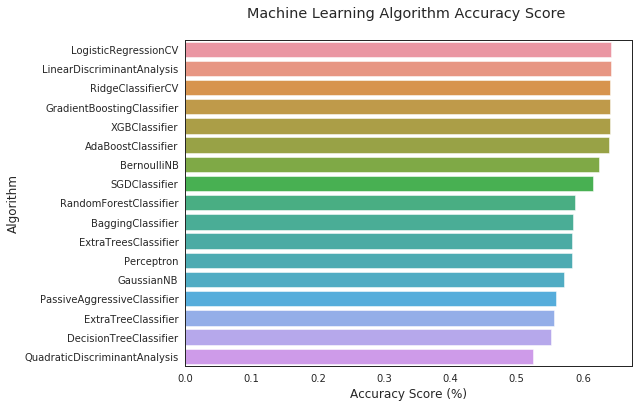

In [24]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
plt.figure(figsize=(8,6))
sns.barplot(x='Accuracy', y = 'ModelName', data = MLA_compare[MLA_compare['Dataset']== 'ValidSet'], palette=sns.husl_palette(n_colors=20,l=.7))

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')
plt.show()

In [25]:
top_models = MLA_compare[:4]['ModelName'].values # 상위 4개 모델 Tuninig
top_models

array(['LogisticRegressionCV', 'LinearDiscriminantAnalysis',
       'RidgeClassifierCV', 'GradientBoostingClassifier'], dtype=object)

In [0]:
# TEST SET 결과 출력 사용자 함수
def result_summary(model, x, y):
  pred_y = model.predict(x)
  pred_y = (pred_y>0.5)
  print("Accuracy: {:.4f}".format(accuracy_score(y, pred_y)))
  print("Confusion Matrix: \n", confusion_matrix(y, pred_y))
  print("Classification Report Matrix: \n", classification_report(y, pred_y, digits=3))

  roc_auc = roc_auc_score(y, pred_y)
  print("roc_auc score is : {:.4f}".format(roc_auc))

  fpr, tpr, threshold = roc_curve(y, pred_y)
  roc_auc = auc(fpr, tpr)

  auc_graph(roc_auc, fpr, tpr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy: 0.6431
Confusion Matrix: 
 [[6468 3612]
 [3525 6395]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.647     0.642     0.644     10080
         1.0      0.639     0.645     0.642      9920

    accuracy                          0.643     20000
   macro avg      0.643     0.643     0.643     20000
weighted avg      0.643     0.643     0.643     20000

roc_auc score is : 0.6432


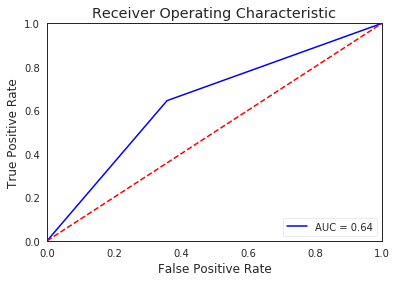

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy: 0.6436
Confusion Matrix: 
 [[6470 3610]
 [3518 6402]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.648     0.642     0.645     10080
         1.0      0.639     0.645     0.642      9920

    accuracy                          0.644     20000
   macro avg      0.644     0.644     0.644     20000
weighted avg      0.644     0.644     0.644     20000

roc_auc score is : 0.6436


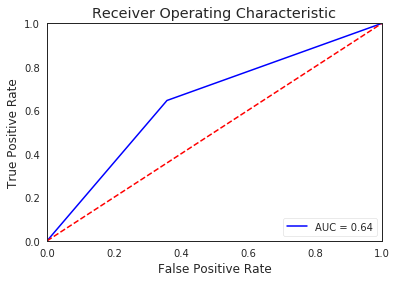

In [27]:
lr_clf = linear_model.LogisticRegression()
lr_clf.fit(train_x, train_y)
print(lr_clf)

# GridSearch 이전 기본 모델 출력
result_summary(lr_clf, test_x, test_y)

# RandomizedSearchCV 결과 Accuracy향상으로 최적 파라미터 찾아 아래 코드 수행 안함

# param_grid = {}
# param_grid["C"] =  [0.001, 0.01, 0.1, 10]
# param_grid["penalty"] =  ['l1','l2']
# param_grid["max_iter"] = [100,150]

# grid_lr_clf = GridSearchCV(lr_clf, param_grid)
# grid_lr_clf.fit(train_x, train_y)
# print(grid_lr_clf.best_estimator_)

# # GridSearch 이후 결과 출력
# result_summary(grid_lr_clf.best_estimator_, test_x, test_y) 

In [0]:
# RandomizedSearchCV의 Logistic Regression Tuning 결과 : 0.6431에서 0.6436으로 성능 향상
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)
Accuracy: 0.6439
Confusion Matrix: 
 [[6494 3586]
 [3537 6383]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.647     0.644     0.646     10080
         1.0      0.640     0.643     0.642      9920

    accuracy                          0.644     20000
   macro avg      0.644     0.644     0.644     20000
weighted avg      0.644     0.644     0.644     20000

roc_auc score is : 0.6438


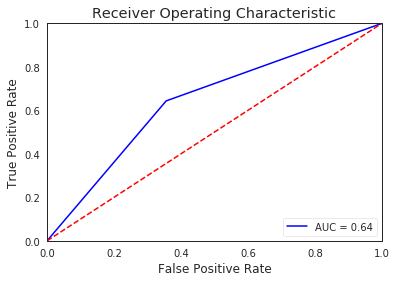

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   36.5s finished


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='sparse_cg', tol=0.001)
Accuracy: 0.6433
Confusion Matrix: 
 [[6494 3586]
 [3547 6373]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.647     0.644     0.645     10080
         1.0      0.640     0.642     0.641      9920

    accuracy                          0.643     20000
   macro avg      0.643     0.643     0.643     20000
weighted avg      0.643     0.643     0.643     20000

roc_auc score is : 0.6433


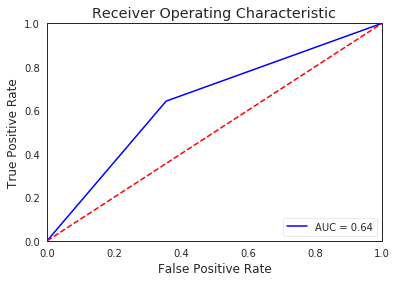

In [47]:
# RidgeClassifier
rc_clf = linear_model.RidgeClassifier()
rc_clf.fit(train_x, train_y)
print(rc_clf)

# GridSearch 이전 기본 모델 출력
result_summary(rc_clf, test_x, test_y)

# RandomizedSearchCV 결과 Accuracy: 0.0.6433으로  0.6439보다 낮아 동일하여 아래 코드 수행 안함

# params = {
#           # "alpha": st.uniform(1e-3, 1),
#           'solver' : ['auto', 'svd','cholesky','lsqr', 'sparse_cg', 'sag', 'saga']
#           }

# # grid_rc_clf = GridSearchCV(rc_clf, param_grid)  
# rs_rc_clf = RandomizedSearchCV(rc_clf, params, n_jobs=-1, cv=2, verbose=1)  
# rs_rc_clf.fit(train_x, train_y)
# print(rs_rc_clf.best_estimator_)

# # GridSearch 이후 결과 출력
# result_summary(rs_rc_clf.best_estimator_, test_x, test_y)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
Accuracy: 0.6435
Confusion Matrix: 
 [[6494 3586]
 [3544 6376]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.647     0.644     0.646     10080
         1.0      0.640     0.643     0.641      9920

    accuracy                          0.643     20000
   macro avg      0.643     0.643     0.643     20000
weighted avg      0.644     0.643     0.644     20000

roc_auc score is : 0.6435


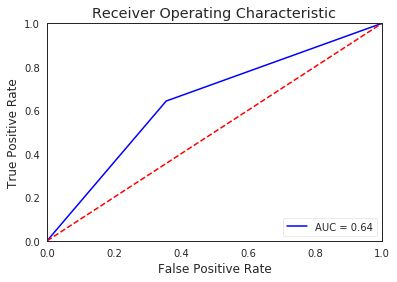

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   59.6s finished


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False,
                           tol=0.00023997553471936117)
Accuracy: 0.6435
Confusion Matrix: 
 [[6494 3586]
 [3544 6376]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.647     0.644     0.646     10080
         1.0      0.640     0.643     0.641      9920

    accuracy                          0.643     20000
   macro avg      0.643     0.643     0.643     20000
weighted avg      0.644     0.643     0.644     20000

roc_auc score is : 0.6435


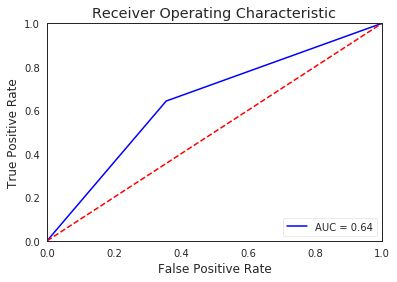

In [42]:
lda_clf = discriminant_analysis.LinearDiscriminantAnalysis()
lda_clf.fit(train_x,train_y)
print(lda_clf)

# GridSearch 이전 기본 모델 출력
result_summary(lda_clf, test_x, test_y)


# RandomizedSearchCV 결과 Accuracy: 0.6435로 동일하여 아래 코드 수행 안함
# params = {
#            "solver":['svd', 'lsqr'],
#            "tol": st.uniform(1.0e-5, 1.0e-3),
#         }
# rs_lad_clf = RandomizedSearchCV(lda_clf, params, n_jobs=-1, cv=3, verbose=1)  

# rs_lad_clf.fit(train_x, train_y)
# print(rs_lad_clf.best_estimator_)

# # GridSearch 이후 결과 출력
# result_summary(rs_lad_clf.best_estimator_, test_x, test_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, nthreads=-1, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)
Accuracy: 0.6436
Confusion Matrix: 
 [[6410 3670]
 [3458 6462]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.650     0.636     0.643     10080
         1.0      0.638     0.651     0.645      9920

    accuracy                          0.644     20000
   macro avg      0.644     0.644     0.644     20000
weighted avg      0.644     0.644     0.644     20000

roc_auc score is : 0.6437


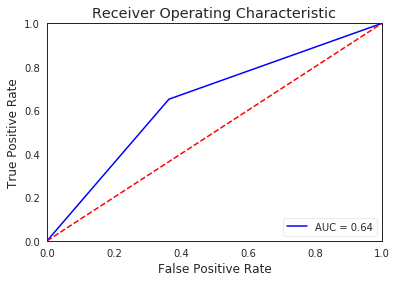

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 12.2min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9954227711332254,
              gamma=4.4387091415399835, learning_rate=0.5931116776605618,
              max_delta_step=0, max_depth=31,
              min_child_weight=50.14224905929251, missing=None, n_estimators=20,
              n_jobs=1, nthread=None, nthreads=-1, objective='binary:logistic',
              random_state=0, reg_alpha=88.099034189603, reg_lambda=1,
              scale_pos_weight=1, seed=None, silent=None,
              subsample=0.9978691522916254, verbosity=1)
Accuracy: 0.6446
Confusion Matrix: 
 [[6259 3821]
 [3286 6634]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.656     0.621     0.638     10080
         1.0      0.635     0.669     0.651      9920

    accuracy                          0.645     20000
   macro avg      0.645     0.645     0.645     20000
weighted avg      0.645  

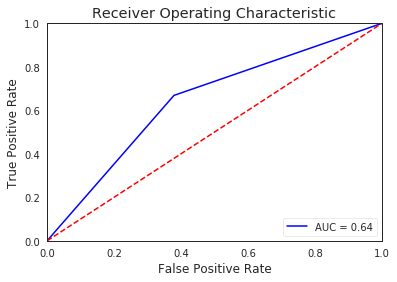

In [30]:
# XGBoost Test
xgb_clf = XGBClassifier(nthreads=-1)
xgb_clf.fit(train_x,train_y)
print(xgb_clf)

# GridSearch 이전 기본 모델 출력
result_summary(xgb_clf, test_x, test_y)

# RandomizedSearchCV 결과 Accuracy: 0.6436에서 0.6446으로 성능 향상 하여 최적 파라미터 찾아 아래 코드 수행 안함

# one_to_left = st.beta(100, 1)  
# from_zero_positive = st.expon(0, 50)

# params = {  
#     "n_estimators": st.randint(3, 100),
#     "max_depth": st.randint(3, 40),
#     "learning_rate": st.uniform(0.05, 0.9),
#     "colsample_bytree": one_to_left,
#     "subsample": one_to_left,
#     "gamma": st.uniform(0, 10),
#     'reg_alpha': from_zero_positive,
#     "min_child_weight": from_zero_positive,
# }

# rand_xgb_clf = RandomizedSearchCV(xgb_clf, params, n_jobs=-1, cv=2, verbose=1)  
# rand_xgb_clf.fit(train_x, train_y) 
# print(rand_xgb_clf.best_estimator_)

# # GridSearch 이후 결과 출력
# result_summary(rand_xgb_clf.best_estimator_, test_x, test_y) 

In [0]:
# RandomizedSearchCV의 XGBClassifier Tuning 결과 : 0.6436에서 0.6446으로 성능 향상

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9954227711332254,
              gamma=4.4387091415399835, learning_rate=0.5931116776605618,
              max_delta_step=0, max_depth=31,
              min_child_weight=50.14224905929251, missing=None, n_estimators=20,
              n_jobs=1, nthread=None, nthreads=-1, objective='binary:logistic',
              random_state=0, reg_alpha=88.099034189603, reg_lambda=1,
              scale_pos_weight=1, seed=None, silent=None,
              subsample=0.9978691522916254, verbosity=1)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Accuracy: 0.6427
Confusion Matrix: 
 [[6444 3636]
 [3511 6409]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.647     0.639     0.643     10080
         1.0      0.638     0.646     0.642      9920

    accuracy                          0.643     20000
   macro a

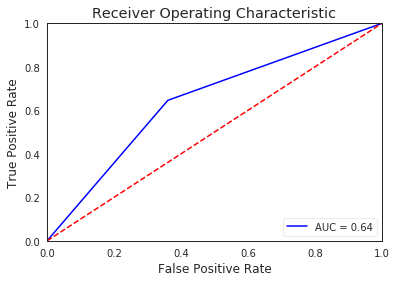

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [0]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(train_x,train_y)
print(gb_clf)

# GridSearch 이전 기본 모델 출력
result_summary(gb_clf, test_x, test_y)

one_to_left = st.beta(100, 1)  
from_zero_positive = st.expon(0, 50)

params = {
    "loss":["deviance"],
    "learning_rate": st.uniform(0.01, 0.2),
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":st.randint(3, 8),
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":st.uniform(0.5, 0.5),
    }

rs_gb_clf = RandomizedSearchCV(gb_clf, params, n_jobs=-1, cv=2, verbose=1)  
rs_gb_clf.fit(train_x, train_y) 
print(rs_gb_clf.best_estimator_)

# GridSearch 이후 결과 출력
result_summary(rs_gb_clf.best_estimator_, test_x, test_y) 